In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
events_data = pd.read_csv('event_data_train.csv')

In [5]:
submissions_data = pd.read_csv('submissions_data_train.csv')

In [6]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [7]:
events_data.head(10) # unix time

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [8]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [9]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [10]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [11]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [12]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [13]:
events_data['day'] = events_data.date.dt.date

In [14]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


<AxesSubplot:xlabel='day'>

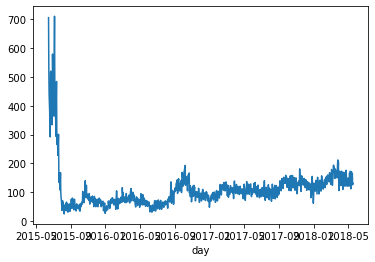

In [15]:
events_data.groupby('day') \
    .user_id.nunique().plot()

<AxesSubplot:>

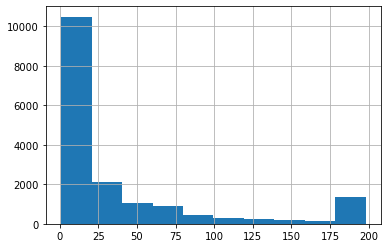

In [16]:
# INCORRECT SOLUTION!
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id' : 'count'}) \
    .rename(columns={'step_id' : 'passed_steps'}).passed_steps.hist()

#### Однако, пользователи, у которых нет ни одного passed стэпа вообще не попадут в результат.

In [17]:
# проверяем так, чтобы никогда не терять уников в процессе анализа

In [18]:
events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count',
                        fill_value=0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [19]:
users_events_data = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count',
                        fill_value=0).reset_index()

In [20]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [21]:
users_scores = submissions_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count',
                        fill_value=0).reset_index()

In [22]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [23]:
events_data[['step_id', 'user_id']].head().drop_duplicates() #useful

,step_id,user_id
0,32815,17632
3,32811,17632


In [24]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [25]:
gap_data =  pd.Series(np.concatenate(gap_data, axis=0))
# axis = 0 – rows, whereas axis = 1 – columns

In [26]:
gap_data = gap_data / (24 * 60 * 60)

<AxesSubplot:>

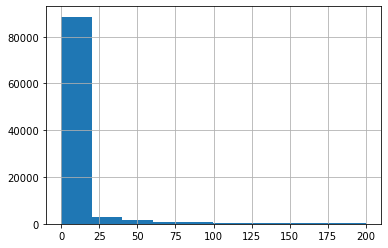

In [27]:
gap_data[gap_data < 200].hist()

In [28]:
gap_data.quantile(0.95) 
# only 5% of the users return to the course
# after gap in 59 days

59.760440972222156

In [29]:
gap_data.quantile(0.90) 

18.325995370370403

In [30]:
# Какого времени достаточно, чтобы считать пользователя дропнушивмся?

In [31]:
gap_data.quantile(0.90)  / (24 * 60 * 60)

0.00021210642789780559

In [32]:
30 * 24 * 60 * 60 # timestamp porogowy

2592000

In [33]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [34]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp' : 'max'}).rename(columns={'timestamp' : 'last_timestamp'})

In [35]:
now = 1526772811
drop_out_threshold = 2592000

In [36]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold

In [37]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [38]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [39]:
users_data = users_data.fillna(0)

In [40]:
users_data = users_data.merge(users_events_data, how='outer')

In [41]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [42]:
users_data = users_data.merge(users_days, how='outer')

In [43]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [44]:
users_data['passed_course'] = users_data.passed > 170

In [45]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [46]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [47]:
users_data.user_id.nunique()

19234

In [48]:
events_data.user_id.nunique()

19234

In [52]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [53]:
users_data[users_data.passed_course].day.median()

20.0

<AxesSubplot:>

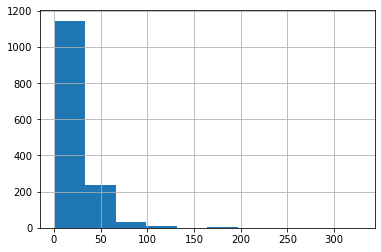

In [54]:
users_data[users_data.passed_course].day.hist()

In [171]:
# when user firstly did something active on course
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp' : 'min'}) \
    .rename({'timestamp' : 'min_timestamp'}, axis=1)

In [172]:
users_data = users_data.merge(user_min_time, how='outer')

In [173]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [174]:
event_data_train = pd.DataFrame()

In [ ]:
# too long

# for user_id in users_data.user_id:
#     min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
#     time_threshold = min_user_time + 3 * 24 * 60 * 60
    
#     users_events_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_threshold)]
    
#     event_data_train = event_data_train.append(users_events_data)

In [175]:
event_data_train = events_data[events_data.user_id < events_data.timestamp]

In [176]:
# Отобрать данные, которые впис. в промежуток первых 3 дня курса
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [177]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [178]:
learning_time_threshold = 3 * 24 * 60 * 60
learning_time_threshold

259200

In [179]:
#макс значение времени, после которого мы уже не будем использовать данные
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)

In [180]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [181]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

In [182]:
events_data.shape

(3480703, 8)

In [183]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [184]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]

In [185]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [186]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [187]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [188]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename(columns={'day' : 'days'})

In [189]:
step_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns={'step_id' : 'steps_tried'})

In [190]:
X = X.merge(step_tried, on='user_id', how='outer')

In [191]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [193]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                                  columns='submission_status',
                                  values='step_id',
                                  aggfunc='count',
                                  fill_value=0).reset_index())

In [194]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [195]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [196]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                                  columns='action',
                                  values='step_id',
                                  aggfunc='count',
                                  fill_value=0).reset_index()[['user_id','viewed']], how='outer')

In [197]:
X.fillna(0)

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1
19230,26781,0.0,0.0,0.0,0.0,0.00,6
19231,26788,0.0,0.0,0.0,0.0,0.00,1
19232,26789,0.0,0.0,0.0,0.0,0.00,2


In [198]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [199]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [200]:
y = X.passed_course.map(int)

In [201]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [202]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [203]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


In [204]:
# żeby nie zapomniać
X.to_csv('X_data.csv')
y.to_csv('Y_data.csv')

#### practice easter egg (step 1)

In [49]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [50]:
events_data.action.value_counts()

viewed             1830830
discovered          689495
passed              650331
started_attempt     310047
Name: action, dtype: int64

In [51]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [64]:
submissions_data

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


In [71]:
submissions_data[submissions_data.submission_status == 'correct'] \
.groupby('user_id', as_index=False) \
.agg({'submission_status' : 'count'}) \
.sort_values(by=['submission_status'], ascending=False).head(20)


,user_id,submission_status
433,1046,421
2062,5552,186
6323,17135,168
2302,6183,142
3151,8461,135
508,1218,130
8761,24022,121
5424,14699,121
8,30,119
8288,22713,117


## 2.10 quiz

In [108]:
submissions = pd.read_csv('submissions_data_train.csv')

In [109]:
submissions.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [111]:
only_wrong = submissions[submissions['submission_status'] == 'wrong']

In [118]:
only_wrong.step_id.value_counts().head(1)

31978    16084
Name: step_id, dtype: int64